The normal chest x rays are clear with no white clouds. But in the bacterial pneumonia affected chest X-ray, we can find some focal white clouds, whereas in viral ammonia we can see that the white clouds are a little more diffused.

Problem Statement

Pneumonia isNan infection that inflames the air sacs in one or both the lungs, which may fill with fluid or pus, the infection can be life threatening to anyone, but particularly to infants, children and people over 65. The germs that cause pneumonia are very contagious, both viral antibacterial pneumonia can spread to others through inhalation of airborne droplets from a sneeze or a cough, or by coming into contact with surfaces or objects that are contaminated with pneumonia causing bacteria or viruses.

Major symptoms that can lead to pneumonia- Pneumonia symptoms can be mild to life threatening.They can include coughing that may produce mucus, sweating or chills.Shortness of breath that happens while doing normal activities or even while resting. Chest pain, that is worse when you breathe or cough. Feeling of tiredness or fatigue, loss of appetite, nausea or vomiting, headaches.

Let us also understand how chest X-rays are related to pneumonia, disease. First of all, an X-ray exam will allow a doctor to see the lungs, heart and blood vessels,etc. to determine the presence of pneumonia. While interpreting the X-ray, the radiologist will look for white spots in the lungs, also known as infiltrates, that identify an infection. However, the image quality of chest X-ray has some defects, such as a low contrast or overlapping organs and blood boundary which seriously affect detecting pneumonia in chest X-rays. Therefore, it has important medical value and application significance to construct a stable and accurate automatic detection model of pneumonia through a large number of chest X-ray images.


In [ ]:
# Data hosted at below link (downloading it)
!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
# Unzipping the data
!unzip -q "archive.zip"

--2022-11-09 06:30:33--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tlxserrdhe240lu/archive.zip [following]
--2022-11-09 06:30:34--  https://www.dropbox.com/s/raw/tlxserrdhe240lu/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucace454248736eebb5c4836294b.dl.dropboxusercontent.com/cd/0/inline/BwZZq8885NEHOFsR7I0SprxVPYWzxawxve7zj5Ejmr6isqk0ZzvwQjiX7DayNAagM5aVaxlFr1qjI8JAWe1IJY8j83ldvQyVdoddZP5xaF2xVcxO-oxUw4b65Wn6aV78gKCJOBRmhElOP9NFcJ7YCYcQh-1jIZZNxFAcCNrqG78JyA/file# [following]
--2022-11-09 06:30:34--  https://ucace454248736eebb5c4836294b.dl.dropboxusercontent.com/cd/0/inline/BwZZq8885NEHOFsR7I0SprxVPYWzxawxve7zj5Ejmr6isqk0ZzvwQjiX7DayNAagM5aVaxlFr1qjI8JA

In [ ]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [ ]:
# Creating the Pathlib PATH objects
train_path = Path("chest_xray/train/")
validation_path = Path("chest_xray/test")
test_path = Path("chest_xray/val")

In [ ]:
# Collecting all the Paths Inside "Normal" and "Pneumonia" folders of the above paths
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

# Output is a Generator object
print(train_image_paths)

#Currently, we need to fetch all the parts inside both normal and pneumonia folders, which are by themselves sub folders.
#So to fetch them we write star slash star..

<generator object Path.glob at 0x7f36ec8260d0>


In [ ]:
# Convert Generator Object to List of elements 
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

# Now the outputs are "PosixPath" objects
print(train_image_paths[:3])

[PosixPath('chest_xray/train/NORMAL/IM-0191-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-1039-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-1001-0001.jpeg')]


In [ ]:
# Convert Posix paths to normal strings
train_image_paths = list(map(lambda x : str(x) , train_image_paths))
val_image_paths = list(map(lambda x : str(x) , val_image_paths)) 

print(train_image_paths[:3])

['chest_xray/train/NORMAL/IM-0191-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-1039-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-1001-0001.jpeg']


In [ ]:
# Collect Length for Training and Validation Datasets
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

In [ ]:
# Every Image has Label in its path , so lets slice it 
LABELS = {'NORMAL' : 0 , 'PNEUMONIA' : 1}
INV_LABELS = {0 : 'NORMAL', 1 : 'PNEUMONIA'}

def get_label(path : str) -> int:
    return LABELS[path.split("/")[-2]]

#we assign a unique label to each class of images and also maintain an in both mapping dictionary.
train_labels = list(map(lambda x : get_label(x) , train_image_paths))
val_labels = list(map(lambda x : get_label(x) , val_image_paths))

print(train_labels[:3])

[0, 0, 0]


In [ ]:
# Now we have all training, validation image paths and their respective labels 

BATCH_SIZE = 32

# Function used for Transformation
def load_and_transform(image , label , train = True):
    image = tf.io.read_file(image) # takes string as the argument and returns encoded string 
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    if train:
        image = tf.image.random_flip_left_right(image)
    return image , label

# Function used to Create a Tensorflow Data Object
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset)).shuffle(1000)

    dataset = dataset.map(lambda image , label : load_and_transform(image , label , train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [ ]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(train_image_paths , train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 691 ms, sys: 410 ms, total: 1.1 s
Wall time: 2.53 s
(32, 224, 224, 3)
(32,)


PNEUMONIA


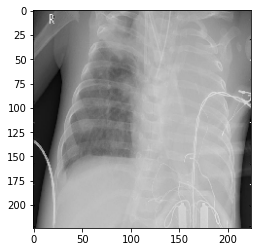

In [ ]:
# View a sample Train Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [ ]:
%time val_dataset = get_dataset(val_image_paths , val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 17.6 ms, sys: 0 ns, total: 17.6 ms
Wall time: 17.8 ms
(32, 224, 224, 3)
(32,)


PNEUMONIA


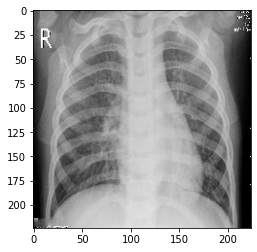

In [ ]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [ ]:
# Building ResNet50 model
#ResNet-50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer).
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape=(224, 224, 3), #shape of processed image
    include_top=False #to remove the final layer
)

model = tf.keras.Sequential([  #to join multiple tensorflow graphs sequentially 
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid') #use sigmoid as we have to output yes or a no and sigmoid outputs 0 or 1
])

model.summary()

94668760/94668760 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy', #as we are solving binary classification
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# Defining our callbacks 
#tensorflow callback object is used to perform an action in various stages of training process 

checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
#used to save a model or weights at a particular frequency

early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

#EARLYSTOPPING CALLBACK IS USED TO STOP THE TRAINING PROCESS BEFORE OUR MODEL TRIES TO OVER LEARN THE DATA ie, OVER FITTING. IT TAKES IN AN
#ARGUMENT CALLED 'PATIENCE' wwhich is number of epochs with no improvemetn 


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_length//BATCH_SIZE,  #determines the number of batches to be loaded from the data object by one epoch
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = val_dataset_length//BATCH_SIZE,
)

#accuarcy and loss are default metrics and are saved in 'history' variable.....we have additionally passed in precision and recall

Epoch 1/8
163/163 [==============================] - ETA: 0s - loss: 0.1650 - accuracy: 0.9433 - precision: 0.9583 - recall: 0.9560
Epoch 1: val_loss improved from inf to 4.06201, saving model to best_weights.h5
163/163 [==============================] - 135s 597ms/step - loss: 0.1650 - accuracy: 0.9433 - precision: 0.9583 - recall: 0.9560 - val_loss: 4.0620 - val_accuracy: 0.5395 - val_precision: 1.0000 - val_recall: 0.2689
Epoch 2/8
163/163 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.9749 - precision: 0.9831 - recall: 0.9829
Epoch 2: val_loss improved from 4.06201 to 2.66347, saving model to best_weights.h5
163/163 [==============================] - 100s 612ms/step - loss: 0.0690 - accuracy: 0.9749 - precision: 0.9831 - recall: 0.9829 - val_loss: 2.6635 - val_accuracy: 0.5033 - val_precision: 0.9205 - val_recall: 0.2154
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9735 - precision: 0.9817 - recall: 0.9827
Epoch 

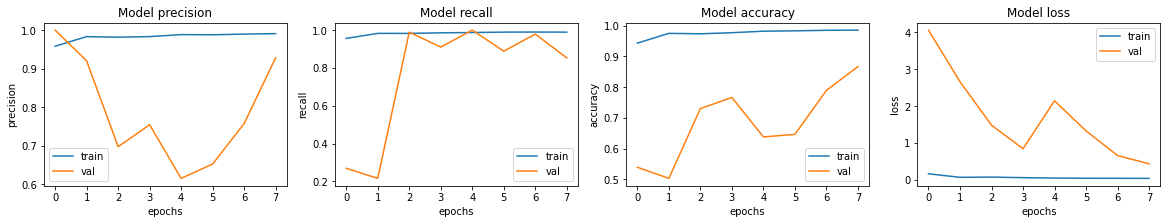

In [ ]:
# Interpreting the Metrics 
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#if loss starts increasing and never decreases, it is an over-fitted model

In [ ]:
# Saving the best Model

# Load the best weights
model.load_weights("best_weights.h5")
# Save the whole model (weigths + architecture)
model.save("model.h5")

In [ ]:
# Loading the whole model
loaded_model = tf.keras.models.load_model("model.h5")

Create a Testing Dataset

In [ ]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [ ]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


NORMAL


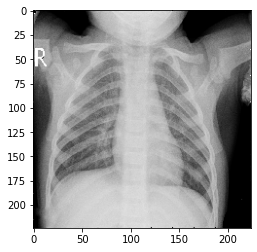

In [ ]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [ ]:
# Evaluating the loaded model
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

1/1 [==============================] - 2s 2s/step - loss: 0.6747 - accuracy: 0.8750 - precision: 1.0000 - recall: 0.7500
 Testing Acc :  0.875
 Testing Precision  1.0
 Testing Recall  0.75
